# 11-experiment-three-cogsci

## Integrity

In [1]:
# Analytical Tools
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# General Utilities
import itertools
import json
import pprint

# Custom Utilities
import utilities.plotting as plotting
import utilities.describe as describe

# Some settings
log = pprint.pprint
%matplotlib inline
pd.options.mode.chained_assignment = None

### Reading Data

In [2]:
QUESTIONS = 10
JUDGMENTS = 4

FILE_NAMES = [
    'data/baseline_final.json', #raw is initial one that may have duplicates, we take the non-duplicates from it
    'data/raw.json',
]

master_responses = []
for name in FILE_NAMES:
    with open(name) as file:
        master_responses.extend(json.loads(line) for line in file if line)

### Parsing Data

In [3]:
data = {
    'id': [],
    'consent': [],
    'attention': []
}

for q_num in range(QUESTIONS):
    data['q{}_score'.format(q_num)] = []
    data['q{}_index'.format(q_num)] = []
    for j_num in range(JUDGMENTS):
        data['q{}_j{}'.format(q_num, j_num)] = []

In [4]:
ANSWER_KEYS = ('Q0', 'Q1', 'Q2', 'Q3')

for person in master_responses:
    # Grab data & ID
    person_data = person['data']  
    data['id'].append(person_data[0]['participantID'])
    
    # Fill in question labels
    question_scores = person_data[0]['questionScores']
    question_indices = person_data[0]['questionIndices']
    
    for q_num, score in zip(range(QUESTIONS), question_scores):
        data['q{}_score'.format(q_num)].append(score)
    for q_num, score in zip(range(QUESTIONS), question_indices):
        data['q{}_index'.format(q_num)].append(score)  
    
    # Get consent response
    consent_answer = json.loads(person_data[0]['responses'])
    consent_value = int(consent_answer['Q0'].startswith('I consent'))
    data['consent'].append(consent_value)

    # Fill in judgments
    judgment_indices = person_data[0]['judgmentIndices']
    
    for q_num, likert_index in zip(range(QUESTIONS), range(2, 12)):
        answer = json.loads(person_data[likert_index]['responses'])
        for j_label, key in zip(judgment_indices, ANSWER_KEYS):
            rating = int(answer[key])
            data['q{}_j{}'.format(q_num, j_label)].append(rating)

    # Attention check
    attention_answer = json.loads(person_data[7]['responses'])
    attention_value = int(attention_answer['Q4'] == '6')
    data['attention'].append(attention_value)

### Reading Responses into Data

In [5]:
data = pd.DataFrame(data)
sample_size = len(data)
data.head()


,attention,consent,id,q0_index,q0_j0,q0_j1,q0_j2,q0_j3,q0_score,q1_index,...,q8_j1,q8_j2,q8_j3,q8_score,q9_index,q9_j0,q9_j1,q9_j2,q9_j3,q9_score
0,1,1,sfmcx2twvmsm0d9qpnq19vpmrd27oqtr,18,4,0,0,0,None,24,...,2,3,3,None,37,0,6,6,3,None
1,1,1,qrw87p430tabkol0mxj9q3dkm1p4o423,5,5,1,4,2,None,29,...,4,5,1,None,23,4,1,3,1,None
2,0,1,2yfjc32hqne6avf0a6kaxbhftw6ydo47,26,0,1,0,1,None,30,...,3,4,4,None,41,0,0,0,0,None
3,1,1,076dogp6qxwgm1aqfmdryebkh30e4w9m,20,3,0,1,1,None,25,...,0,3,1,None,40,0,0,0,0,None
4,1,1,um8loq05sq31yj9f54c4rhxfhjsx7uac,38,1,0,0,0,None,3,...,4,1,2,None,27,3,3,2,2,None


In [6]:
print(len(data), data.size)
data = data[data.consent == 1]
print(len(data), data.size)
data = data[data.attention == 1]
print(len(data), data.size)

print('Inclusion: {:.4}% '.format(len(data) / sample_size * 100))

298 18774
298 18774
278 17514
Inclusion: 93.29% 


In [7]:
judgments = []
for q_num in range(QUESTIONS):
    for j_num in range(JUDGMENTS):
        judgments.append('q{}_j{}'.format(q_num, j_num))
scores = data[judgments]
data['j_mean'] = scores.mean(axis=1)
data['j_std'] =scores.std(axis=1)



In [8]:
print(len(data), data.size)
data = data[data.j_std > 0.75]
index = np.argmin(data['j_std'])
print(scores.loc[[index]].values)
print('Inclusion: {:.4}% '.format(len(data) / sample_size * 100))

278 18070
[[3 2 2 2 3 3 2 2 4 3 3 3 4 2 4 4 4 2 3 3 3 2 3 3 4 2 4 4 3 3 3 3 2 2 2 2 4
  2 3 3]]
Inclusion: 91.61% 


C:\Users\RACH0_000\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:1033: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return argmin(axis, out)


## Analysis

In [9]:
for j_num in range(JUDGMENTS):
    headings = []
    for q_num in range(QUESTIONS):
        headings.append('q{}_j{}'.format(q_num, j_num))

    rating_mean = data[headings].mean(axis=1)
    data['j{}_mean'.format(j_num)] = rating_mean

In [10]:
means, errs = [], []
for j_num in range(JUDGMENTS):
    values = data['j{}_mean'.format(j_num)]
    means.append(values.mean())
    errs.append(stats.sem(values))

print(means)
print(errs)

[3.4824175824175803, 1.582051282051283, 2.633333333333334, 2.2274725274725276]
[0.070550098301385214, 0.071240248927516514, 0.07155943983554483, 0.070432448871750916]


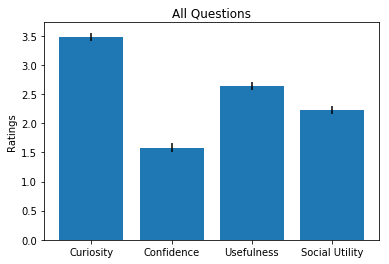

In [11]:
PLOTTING_OPTIONS = {
    'ylabel': 'Ratings',
    'ticks': ['Curiosity', 'Confidence', 'Usefulness', 'Social Utility'],
    'title': 'All Questions'
}
plotting.plot_single_bar(means, errs, **PLOTTING_OPTIONS)